# 3. Procedural scene

## Overview

This tutorial give a brief overview on how to construct a mesh and a Mitsuba scene directly from Python. As in the first tutorial, we will then render and display the produced image.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Create a mesh from scratch</li>
  <li>Edit a mesh object using the traverse mechanism</li>
  <li>Assemble a scene directly in Python</li>
  <li>Transform an existing mesh using the traverse mechanism</li>    
</ul>
    
</div>


### Step 1 - setup things up

For the sake of compliteness, we are going to enable one of the GPU variant of the renderer in this toturial. Although please note that the following Python script should work seemlessly with any other variants.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

### Step 2 - create a mesh from scratch

In [3]:
from mitsuba.core import Float, UInt32, Vector3f, Vector3u
from mitsuba.render import Mesh
from mitsuba.python.util import traverse

# Disk with a wavy fringe parameters
N = 100
frequency = 12.0
amplitude = 0.4

# Generate the vertex positions
t = ek.linspace(Float, 0.0, ek.TwoPi, N)
x, y = ek.sincos(t)
z = amplitude * ek.sin(t * frequency)
vertex_pos = Vector3f(x, y, z)

# Move the last vertex is to the center
vertex_pos[ek.eq(ek.arange(UInt32, N), N-1)] = 0.0

# Generate the face indices
idx = ek.arange(UInt32, N - 1)
face_indices = Vector3u(N - 1, (idx + 1) % (N - 2), idx % (N - 2))

# Create an empty mesh (allocates buffers)
mesh = Mesh("wavydisk", N, N - 1)

# Populate the mesh with the precomputed arrays using the traverse mechanism
mesh_params = traverse(mesh)
mesh_params['vertex_positions'] = ek.ravel(vertex_pos)
mesh_params['faces'] = ek.ravel(face_indices)
mesh_params.update()

It is possible to write the mesh to a ply file like this.

In [4]:
mesh.write_ply('my_mesh.ply')

2021-04-22 15:14:03 INFO main [Mesh] Writing mesh to "my_mesh.ply" ..

2021-04-22 15:14:03 INFO main [Mesh] "my_mesh.ply": wrote 99 faces, 100 vertices (2.33 KiB in 0ms)

### Step 3 - assemble the scene

In [5]:
from mitsuba.core.xml import load_dict
from mitsuba.core import ScalarTransform4f

scene = load_dict({
    'type' : 'scene',
    'integrator' : { 
        'type' : 'path' 
    },
    'light' : { 
        'type' : 'constant' 
    },
    'mesh' : mesh,
    'sensor' : {
        'type' : 'perspective',
        'to_world' : ScalarTransform4f.look_at(origin=[0, -5, 5], 
                                               target=[0, 0, 0], 
                                               up=[0, 0, 1]),
    }
})

2021-04-22 15:14:03 INFO main [Scene] Building scene in OptiX ..

2021-04-22 15:14:03 INFO main [Scene] OptiX ready. (took 35ms)

### Step 4 - render and display

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Start rendering...

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Computation graph recorded. (took 8ms)

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Code generation finished. (took 24ms)

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Rendering finished. (took 40ms)

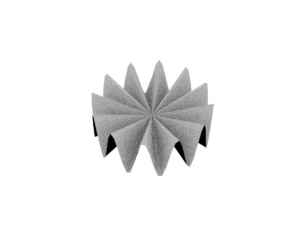

In [6]:
from matplotlib import pyplot as plt
from mitsuba.python.util import render
plt.imshow(render(scene)); plt.axis('off');

### Step 5 - modify the mesh and update the scene

In [7]:
from mitsuba.core import Transform4f

params = traverse(scene)
trans = Transform4f.rotate(axis=[0, 1, 0], angle=30)
vertex_pos = ek.unravel(Vector3f, params['mesh.vertex_positions'])
new_vertex_pos = trans.transform_point(vertex_pos)
params['mesh.vertex_positions'] = ek.ravel(new_vertex_pos)
params.update()

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Start rendering...

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Computation graph recorded. (took 5ms)

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Code generation finished. (took 5ms)

2021-04-22 15:14:03 INFO main [SamplingIntegrator] Rendering finished. (took 19ms)

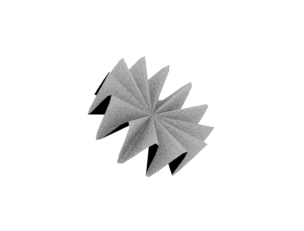

In [8]:
plt.imshow(render(scene)); plt.axis('off');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)
- [<code>mitsuba.core.Transform4f</code>](...)
- [<code>mitsuba.render.Mesh</code>](...)
- [<code>mitsuba.render.Mesh.write_ply</code>](...)
- [<code>mitsuba.python.util.traverse</code>](...)
- [<code>mitsuba.python.util.render</code>](...)
- [<code>mitsuba.python.util.SceneParameters</code>](...)
- [<code>mitsuba.python.util.SceneParameters.update</code>](...)